In [1]:
from torchvision import datasets, transforms
import torchvision
import torch

In [2]:
# add root project to path for imports, this issue is just for notebook environment
import os, sys
from pathlib import Path

def get_project_path(project_name: str) -> Path:
    path = Path(os.path.abspath(''))
    previous_path = None  # Use to prevent infinite loop in case of error
    while path.name != project_name:
        path = path.parent
        if path == previous_path:
            raise ValueError(f"Project '{project_name}' not found in path hierarchy.")
        previous_path = path
    return path

try:
    project_name = "AIProjects"
    project_path = get_project_path(project_name)
    sys.path.append(str(project_path))
except ValueError as e:
    print(f"Project '{project_name}' not found in path hierarchy.")
    try:
        project_name = "machine-learning-portfolio"
        project_path = get_project_path(project_name)
        sys.path.append(str(project_path))
    except ValueError:
        print(f"Project '{project_name}' not found in path hierarchy.")


In [3]:
# Transformations de base (obligatoires)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.4914, 0.4822, 0.4465),
        std=(0.2470, 0.2435, 0.2616)
    )
])

train_dataset = datasets.CIFAR10(
    root="../data",
    train=True,
    transform=transform,
    download=True
)

test_dataset = datasets.CIFAR10(
    root="../data",
    train=False,
    transform=transform,
    download=True
)

In [4]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=2
)

test_loader = DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=2
)

images, labels = next(iter(train_loader))
print(images.shape)   # (64, 3, 32, 32)
print(labels.shape)   # (64,)


torch.Size([64, 3, 32, 32])
torch.Size([64])


# Visualize some images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.48209125..1.555192].


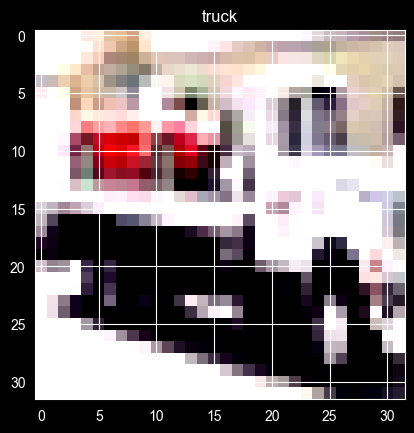

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.008615971..1.2358339].


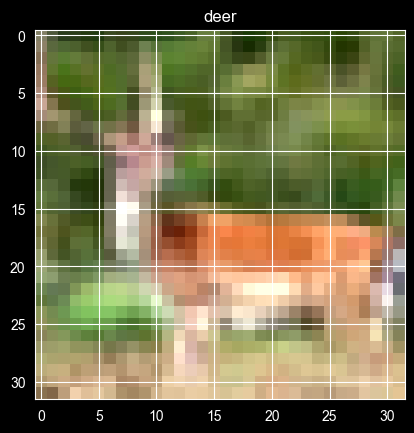

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.24856871..1.3628483].


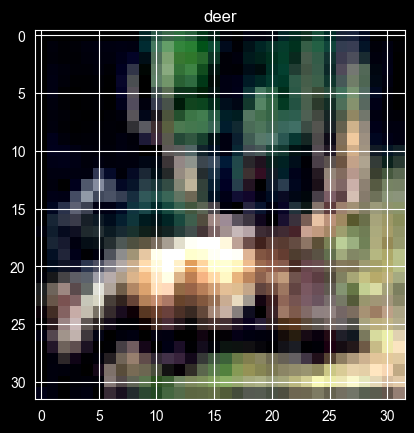

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.43377626..1.4263555].


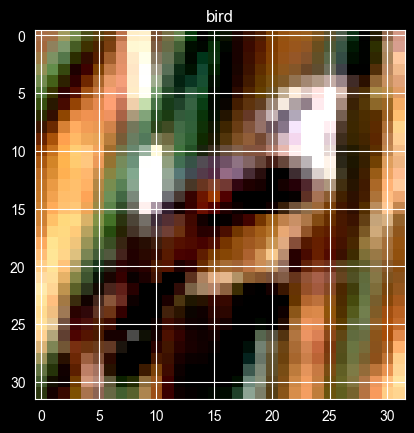

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import random as rnd

def imshow(img, title):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.title(title)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
rnd.seed(42)
ids = rnd.sample(range(len(train_loader.dataset)), 4)
images = [train_loader.dataset[i][0] for i in ids]
labels = [train_loader.dataset.classes[train_loader.dataset[i][1]] for i in ids]

for i, (im, l)in enumerate(zip(images, labels)):
    imshow(im, l)

# Distribution of classes in the training set

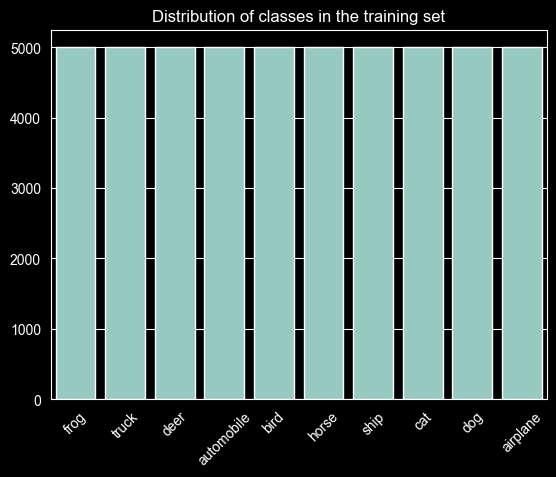

In [6]:
import seaborn as sns

label_counts = dict()
for _, label in train_loader.dataset:
    label_name = train_loader.dataset.classes[label]
    if label_name in label_counts:
        label_counts[label_name] += 1
    else:
        label_counts[label_name] = 1

sns.barplot(x=list(label_counts.keys()), y=list(label_counts.values()))
plt.xticks(rotation=45)
plt.title("Distribution of classes in the training set")
plt.show()

# Training a simple CNN

In [7]:
from computer_vision.src.baseline import BaselineModel
import torch.optim as optim

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BaselineModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [9]:
# Training loop
num_epochs = 10
loss_history = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        preds = model(images)
        loss = model.compute_loss(preds, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader)
    loss_history.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

Epoch [1/10], Loss: 1.1869
Epoch [2/10], Loss: 0.7487
Epoch [3/10], Loss: 0.4493
Epoch [4/10], Loss: 0.1848
Epoch [5/10], Loss: 0.0701
Epoch [6/10], Loss: 0.0623
Epoch [7/10], Loss: 0.0538
Epoch [8/10], Loss: 0.0461
Epoch [9/10], Loss: 0.0423
Epoch [10/10], Loss: 0.0418


## Plot training loss

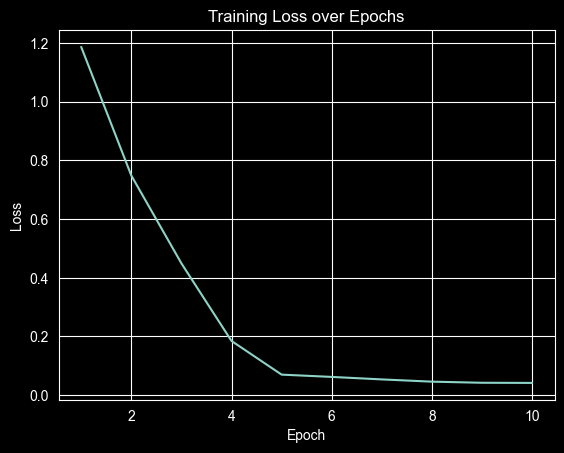

In [10]:
sns.lineplot(x=range(1, num_epochs + 1), y=loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.show()

# Evaluating the model

In [11]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 69.47%


# Finetuning and hyperparameter tuning